## Solution Approach

A mathematical optimization model has five components, namely:

* Sets and indices.
* Parameters.
* Decision variables.
* Objective function(s).
* Constraints.

## Model Formulation

### Sets and Indices

$G(N,E)$: Graph that represents the airport network, where $N$ is the set of vertices and $E$ is the set of edges. The sirports are vertices in the set of nodes $N$ of the graph. The set of flight paths are the edges of the graph.(we assume there is a flight path between each pair of airports) 

$K=\{1,2\}$ represents the depots of JFK and LAX and also represents the plane that start from the depots

### Parameters
$d_{i,j} \in \mathbb{R}^+ $:haversine distance from vertex $i \in N$ to vertex $j \in N$.



### Decision Variables
$x_{ijk} = \begin{cases} 
1 & \text{if plane } k \text{ travels from node } i \text{ to node } j, i \neq j; \\
0 & \text{otherwise.}
\end{cases}$

### Order Variables
$u_{ik}$: The order in which node i is accessed in subtour k.

## Miller-Tucker-Zemlin TSP Formulation
# 
### Objective Function
Minimize the total distance traveled:
# 
$$
\min \sum_{i \in N} \sum_{j \in N} \sum_{k \in K} d_{ij} x_{ijk}
$$
# 
### Constraints
1. Each node must be departed from exactly once:
$$
\sum_{k\in K}\sum_{j \in N-K, j \neq i} x_{ijk} = 1 \quad \forall i \in N-K
$$
2. Each node must be arrived at exactly once:
$$
\sum_{k\in K}\sum_{i \in N-K, i \neq j} x_{ijk} = 1 \quad \forall j \in N-K
$$
3. Plane-Specific Flow Conservation Constraints
plane $k$ can only depart from country $i$ if it has arrived there
$$
\sum_{j \in N, j \neq i} x_{jik} - \sum_{j \in N, j \neq i} x_{ijk} = 0 \quad \forall i \in N-K, \forall k \in K
$$


4. Subtour elimination constraints:
$$
u_{ik} + 1 \leq u_{jk} + (n-1)(1-x_{ijk}), \quad \forall i, j \in N-K, \forall k \in K
$$
5. No self-loops:
$$
x_{iik} = 0 \quad \forall i \in N, \forall k \in K
$$
6. Binary constraints on decision variables:
$$
x_{ijk} \in \{0, 1\} \quad \forall i,j \in N, i \neq j,\forall k \in K
$$
7. Order constraints:
$$
u_{kk} = 1,\forall k \in K
$$
$$
2 \leq u_{ik} \leq n \quad \forall i \in N-K,\forall k \in K 
$$
8. Start and End at Their Respective Depots
Departure from Depot:
$$\sum_{j \in N-K} x_{kjk} = 1 \quad \forall k \in K$$
Return to Depot:
$$\sum_{i \in N-K} x_{ikk} = 1 \quad \forall k \in K$$



In [5]:
from pprint import pprint
import pandas as pd
import networkx as nx
from haversine import haversine, Unit

# Load the data
data = pd.read_csv('airports.csv')
# Add one to the first column value
data['Unnamed: 0'] = data['Unnamed: 0'] + 1

# Create a graph
G = nx.Graph()

# Add nodes
for index, row in data.iterrows():
    G.add_node(row['Unnamed: 0'], country=row['country'], airport_name=row['airport_name'], airport_code=row['airport_code'], 
               latitude_deg=row['latitude_deg'], longitude_deg=row['longitude_deg'])

# Add edges with haversine distance as weight
for i, row1 in data.iterrows():
    for j, row2 in data.iterrows():
        if i != j:
            coord1 = (row1['latitude_deg'], row1['longitude_deg'])
            coord2 = (row2['latitude_deg'], row2['longitude_deg'])
            distance = haversine(coord1, coord2, unit=Unit.MILES)
            G.add_edge(row1['Unnamed: 0'], row2['Unnamed: 0'], weight=distance)

print(G)

Graph with 45 nodes and 990 edges


In [6]:
from gurobipy import *
import gurobipy as gp
import numpy as np
import random

import matplotlib.pyplot as plt
import networkx as nx
# Create a new model
mtz = gp.Model("TSP_MTZ")
mtz.Params.MIPGap = 0.08  # Set the target accuracy to 8% of the optimal

# Create variables
# also satisfy constraint 4 and 5
vars = mtz.addVars([(i, j, k) for i in G.nodes for j in G.nodes for k in [1, 2] if i != j],
                     vtype=GRB.BINARY, name="e")

# Subtour elimination decision variables
u = mtz.addVars([(i, k) for i in G.nodes for k in [1, 2]], vtype=GRB.CONTINUOUS, name="u", lb=1, ub=len(G.nodes))

# Objective: minimize the total distance traveled
mtz.setObjective(gp.quicksum(vars[i, j, k] * G[i][j]['weight'] 
                               for i in G.nodes for j in G.nodes for k in [1, 2] if i != j), GRB.MINIMIZE)

# Constraints
# 1.and 2.
# Each node is entered and left exactly once
# for i in G.nodes:
#     for k in [1, 2]:
#         mtz.addConstr(gp.quicksum(vars[i, j, k] for j in G.nodes if i != j) == 1)
#         mtz.addConstr(gp.quicksum(vars[j, i, k] for j in G.nodes if i != j) == 1)
for i in G.nodes:
        mtz.addConstr(gp.quicksum(vars[i, j, k] for k in [1,2] for j in G.nodes if i != j) == 1)
        mtz.addConstr(gp.quicksum(vars[j, i, k] for k in [1,2] for j in G.nodes if i != j) == 1)

#3. Plane-Specific Flow Conservation Constraints
for i in G.nodes:
    if i not in [1, 2]:
        for k in [1, 2]:
            mtz.addConstr(quicksum(vars[i, j, k] for j in G.nodes if i != j) == quicksum(vars[j, i, k] for j in G.nodes if i != j))

# 4. Subtour elimination constraints (MTZ)
n = len(G.nodes)
for k in [1, 2]:
    for i in list(G.nodes)[2:]:  # Skip the first node
        for j in list(G.nodes)[2:]: 
            if i != j:
                mtz.addConstr(u[i,k] + 1 <= u[j,k] + (n - 1) * (1 - vars[i, j, k]))
for k in [1, 2]:
    mtz.addConstr(u[k, k] == 1)  # Fix the position of the first node for all k in K

# 7.order constraint
for k in [1, 2]:
    for i in list(G.nodes)[2:]:
        mtz.addConstr(u[i, k] >= 2)
        mtz.addConstr(u[i, k] <= len(G.nodes))

# 8. Start and End at Their Respective Depots
# Departure from Depot
for k in [1, 2]:
    # mtz.addConstr(gp.quicksum(vars[k, j, k] for j in G.nodes if k != j) == 1)
    mtz.addConstr(gp.quicksum(vars[k, j, k] for j in G.nodes if (j != 1 and j != 2)) == 1)

# Return to Depot
for k in [1, 2]:
    mtz.addConstr(gp.quicksum(vars[i, k, k] for i in G.nodes if (i != 1 and i !=2)) == 1)


# Solve the model
mtz.optimize()

# Output the solution
if mtz.status == GRB.OPTIMAL:
    edges = [(i, j, k) for i in G.nodes for j in G.nodes for k in [1, 2] if i != j and vars[i, j, k].X > 0.5]
    print("Optimal tour:", edges)
else:
    print("No optimal solution found")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-08
Set parameter MIPGap to value 0.08
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3966 rows, 4050 columns and 26670 nonzeros
Model fingerprint: 0x6efc0dbb
Variable types: 90 continuous, 3960 integer (3960 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [6e+01, 1e+04]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 178 rows and 180 columns
Presolve time: 0.03s
Presolved: 3788 rows, 3870 columns, 25800 nonzeros
Variable types: 86 continuous, 3784 integer (3784 binary)
Found heuristic solution: objective 157792.33350

Root relaxation: objective 2.872059e+04, 136 iterations, 0.00 seconds (0.00 work units)

    No

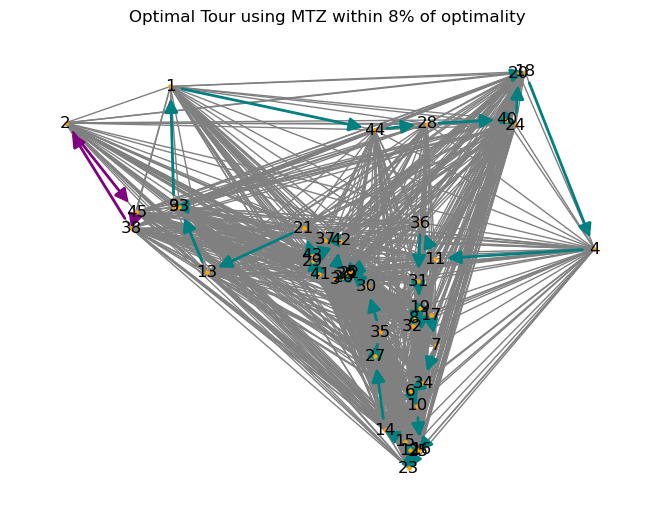

In [7]:
# Define the optimal tour provided by gurobi
optimal_tour_k1 = [(i, j) for i, j, k in edges if k == 1]  # Extract node pairs for k=1
optimal_tour_k2 = [(i, j) for i, j, k in edges if k == 2]  # Extract node pairs for k=2

# Draw the network with the optimal path highlighted
G_optimal_k1 = nx.DiGraph()
G_optimal_k1.add_edges_from(optimal_tour_k1)
G_optimal_k2 = nx.DiGraph()
G_optimal_k2.add_edges_from(optimal_tour_k2)

# Define the positions of the nodes based on latitude and longitude
pos = {node: (G.nodes[node]['longitude_deg'], G.nodes[node]['latitude_deg']) for node in G.nodes}

# Draw the full graph with all nodes
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=5, edge_color='gray', arrows=True)

# Overlay the optimal tour for k=1 with a different edge color
nx.draw_networkx_edges(G_optimal_k1, pos, edge_color='teal', width=2, arrows=True, arrowstyle='-|>', arrowsize=20)

# Overlay the optimal tour for k=2 with another different edge color
nx.draw_networkx_edges(G_optimal_k2, pos, edge_color='purple', width=2, arrows=True, arrowstyle='-|>', arrowsize=20)

plt.title('Optimal Tour using MTZ within 8% of optimality ')
plt.show()

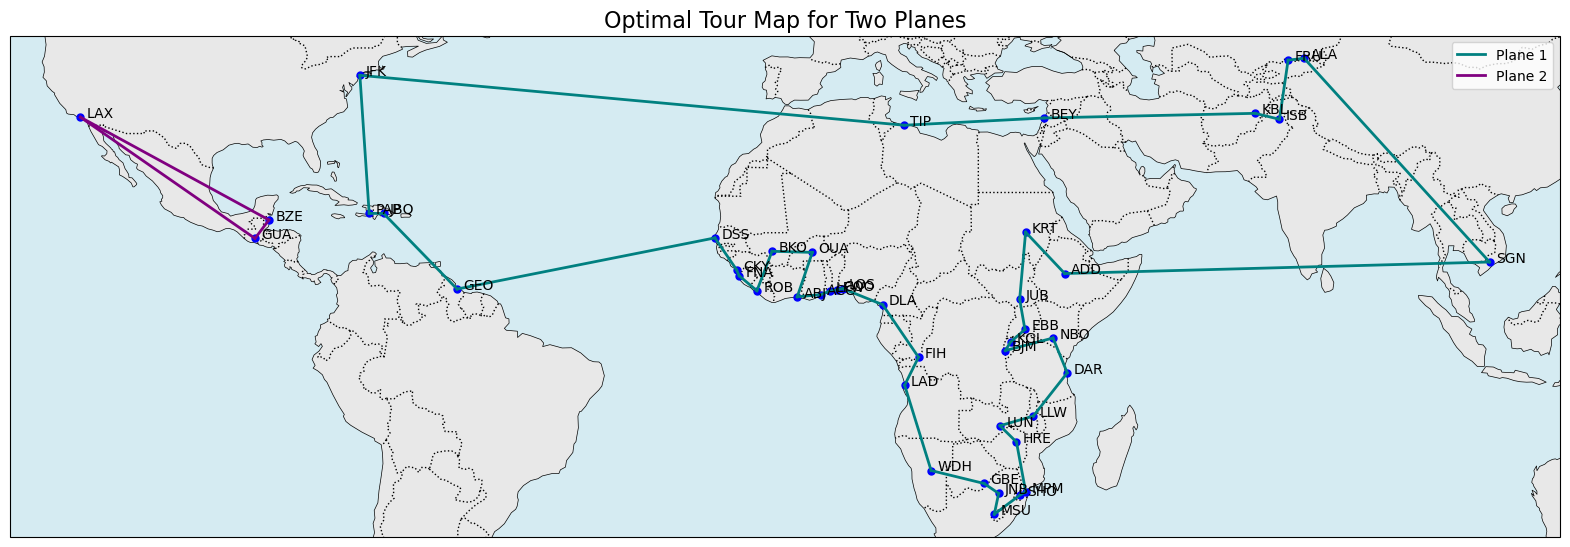

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 提取节点数据
node_data = {row['Unnamed: 0']: (row['latitude_deg'], row['longitude_deg'], row['airport_code'])
             for _, row in data.iterrows()}

# 设置地图投影
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.5)

# 绘制节点
for node, (lat, lon, name) in node_data.items():
    ax.plot(lon, lat, 'bo', markersize=5, transform=ccrs.PlateCarree())  # 绘制节点
    ax.text(lon + 1, lat, f"{name}", fontsize=10, transform=ccrs.PlateCarree())  # 标注节点信息

# 绘制路径，按飞机区分颜色
colors = {1: 'teal', 2: 'purple'}  # 为不同飞机分配颜色
for i, j in optimal_tour_k1:
    lat1, lon1, _ = node_data[i]
    lat2, lon2, _ = node_data[j]
    ax.plot([lon1, lon2], [lat1, lat2], color=colors[1], linewidth=2, transform=ccrs.PlateCarree(), label=f"Plane {1}")
for i, j in optimal_tour_k2:
    lat1, lon1, _ = node_data[i]
    lat2, lon2, _ = node_data[j]
    ax.plot([lon1, lon2], [lat1, lat2], color=colors[2], linewidth=2, transform=ccrs.PlateCarree(), label=f"Plane {2}")


# 去除重复的图例
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)

# 设置标题并显示地图
plt.title("Optimal Tour Map for Two Planes", fontsize=16)
plt.show()